<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Homework Template: Earth Analytics Python Course: Spring 2020

Before submitting this assignment, be sure to restart the kernel and run all cells. To do this, pull down the Kernel drop down at the top of this notebook. Then select **restart and run all**.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below.

* IMPORTANT: Before you submit your notebook, restart the kernel and run all! Your first cell in the notebook should be `[1]` and all cells should run in order! You will lose points if your notebook does not run. 

For all plots and code in general:

* Add appropriate titles to your plot that clearly and concisely describe what the plot shows (e.g. time, location, phenomenon).
* Be sure to use the correct bands for each plot.
* Specify the source of the data for each plot using a plot caption created with `ax.text()`.
* Place ONLY the code needed to create a plot in the plot cells. Place additional processing code ABOVE that cell (in a separate code cell).

Make sure that you:

* **Only include the package imports, code, data, and outputs that are CRUCIAL to your homework assignment.**
* Follow PEP 8 standards. Use the `pep8` tool in Jupyter Notebook to ensure proper formatting (however, note that it does not catch everything!).
* Keep comments concise and strategic. Don't comment every line!
* Organize your code in a way that makes it easy to follow. 
* Write your code so that it can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible.
   2. all paths should be created dynamically using the os package to ensure that they work across operating systems. 
* Check for spelling errors in your text and code comments


In [1]:
NAME = "Robina Shaheen"
COLLABORATORS = "Nicole Kaplan, Sonja wolters, Sara Jaffe"

![Colored Bar](colored-bar.png)

## Work flow to automate NDVI for NEON sites (HARV, SJER)
**Goal**: Automate Normalized Difference Vegetation Indices using Landsat8 multispectral bands for an entire year without clouds.
1.	Import packages required for data processing and plotting.
2.	Download data using earthpy and set working directory to earth-analytics.
3.	Define pixel values to mask clouds and shadows. Define a masking variable to be used later.
4.	Define a function to crop images, produce numpy array, metadata, remove clouds and calculate mean ndvi values for each image.
    * i.	Context manager will be used in conjunction with the earthpy functions to perform this task.
    * ii.	Read and crop quality assurance files that provides information about the clouds and shadows associated with each image.
    * iii.  Read and crop red and infrared bands
    * iv.	Used conditional statement to remove clouds as there may be some clear days.
    * v.	Calculate mean NDVI using Red and Infrared bands and take mean value for each image.
    * vi.	Ultimate goal of this function is to obtain mean NDVI for clear and clouded scenes for both sites that can be saved as a csv file.
5.	Download images for all sites using glob function and sort all data.
6.	Define a composite directory and loop through each site directory. 
    * i.	Obtain sites names in this loop.
    * ii.	Obtain list of sub directories for each site.
    * iii.  Use geopandas to read shape file.
    * iii.	Loop through each subdirectory to get all bands and sort them.
    * iv.	Recall function to calculate mean NDVI for each image and to store in the list.
    * v.    Create a csv file and store in "output" folder.
7.  Define second function to reload file, clean data and create plot by grouping on site.
8.  Recall this function to plot cleaned data for HARV and SJER sites and notice seasonal trends.
9.	Summarize your findings on the trends in "greenness" with mean NDVI and identify growing seasons.
10. Recommendations/ solutions on how weather affects the growing season at each site. 
suggestions about the best time of the year to capture maximum NDVI values.

# Week 07 and 08 Homework - Automate NDVI Workflow

For this assignment, you will write code to generate a plot and an output CSV file of the mean normalized difference vegetation index (NDVI) for two different sites in the United States across one year of data:

* San Joaquin Experimental Range (SJER) in Southern California, United States
* Harvard Forest (HARV) in the Northeastern United States

The data that you will use for this week is available from **earthpy** using the following download: 

`et.data.get_data('ndvi-automation')`

## Assignment Goals

Your goal in this assignment is to create the most efficient and concise workflow that you can that allows for:

1. The code to scale if you added new sites or more time periods to the analysis.
2. Someone else to understand your workflow.
3. The LEAST and most efficient (i.e. runs fast) amount of code that completes the task.

### HINTS

* Remove values outside of the landsat valid range of values as specified in the metadata, as needed.
* Keep any output files SEPARATE FROM input files. Outputs should be created in an outputs directory that is created in the code (if needed) and/or tested for.
* It can help to create the plot and CSV first without cleaning the data to deal with cloud, so you can get a hang of the workflow.  Then, you can modify your workflow to include the cleaning of the data to deal with clouds. (There are tests throughout the notebook that can help you check the data!)


## Assignment Requirements

Your submission to the GitHub repository should include:
* This Jupyter Notebook file (.ipynb) with:
    * The code to create a plot of mean NDVI across the year:
        * NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object
    * The **data should be cleaned to remove the influence of clouds**. See the [earthdatascience website for an example of what your plot might look like with and without removal of clouds](https://www.earthdatascience.org/courses/earth-analytics-python/create-efficient-data-workflows/).
* One output .csv file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV.

Your notebook should:
* Have at least 2 well documented and well named functions with docstrings.
* Include a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code)
* Include additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

In [2]:
# Autograding imports - do not modify this cell
import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

## Import packages to synthesize and plot data.

In [3]:
# Import needed packages in PEP 8 order
# and no unused imports listed (10 points total)
import os
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter 
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.mask as em
import earthpy.plot as ep

# Handle date time conversions between pandas and matplotlib ######### ADD TO LIST
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Adjust plot parameters throughout notebook 
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

### DO NOT REMOVE THIS LINE ###
start_time = datetime.now()

# Figure 1: Plot 1 - Mean NDVI For Each Site Across the Year (50 points)

Create a plot of the mean normalized difference vegetation index (NDVI) for the two different sites in the United States across the year: 

* NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object.
* Each site should be identified with a different color in the plot and legend.
* The final plot **data should be cleaned to remove the influence of clouds**.
* Be sure to include appropriate title and axes labels.

You may additional cells as needed for processing data (e.g. defining functions, etc), but be sure to:
* follow the instructions in the code cells that have been provided to ensure that you are able to use the sanity check tests that are provided. 
* include only the plot code in the cell identified for the final plot code below

## Define mask values

In [4]:
# Define cloud mask to use for all images
high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

# Define name of masking variable
all_masked_values = cloud_shadow + cloud + high_cloud_confidence

## Define Functions to automate data analysis
1. Read and crop bands using earthpy function. 
2. apply QA to mask clouds using conditional statement.
3. calculate mean ndvi for each image.

In [5]:
# Define a function to calculate mean NDVI with and without clouds.
def open_band_ndvi(bands, site_bounds):
    """ 
    Function to calculate mean NDVI values from series of 
    Landsat data sets, as follows:
    Use context manager to:
    - open stacked band.tif 
    - open and crop data following bands
        i. quality assurance (clouds, shades etc.)
        ii. red bands
        iii. Infrared bands
    - use conditional statement to apply QA layer to each band
    - calculate mean for each satellite pass 

    Parameters
    ----------
    bands : tif files containing qa, red, IR band
    band = an integer or number
    site_bounds : .shp file
        .shp file that defines boundaries of study site
   

    Returns
    ---------
    ndvi_mean : int or float
    
    Earthpy function normalized dfference is used to calculate
    ndvi mean value using cropped, cleaned images.
    """    
    
    # use context manager and crop function to open and crop QA
    with rio.open(bands[0]) as qa_src:
        landsat_qa_crop, landsat_qa_meta = es.crop_image(qa_src, site_bounds)
       
    # Open and crop Band 4
    with rio.open(bands[4]) as band_4_src:
        band_4_crop, band_4_meta = es.crop_image(band_4_src, site_bounds)
        
        # Mask Band 4 using QA layer if there are values to mask
        try: 
            band_4_crop_clean = em.mask_pixels(
                arr=band_4_crop, mask_arr=landsat_qa_crop, vals=all_masked_values)             
        except:
            band_4_crop_clean = ma.masked_array(band_4_crop)   
    
    # Open and crop Band 5
    with rio.open(bands[5]) as band_5_src:
        band_5_crop, band_5_meta = es.crop_image(band_5_src, site_bounds)
        
        # Mask Band 5 using QA layer if there are values to mask
        try: 
            band_5_crop_clean = em.mask_pixels(
                arr=band_5_crop, mask_arr=landsat_qa_crop, vals=all_masked_values)             
        except:
            band_5_crop_clean = ma.masked_array(band_5_crop)            
    
    # Calculate mean NDVI
    ndvi_mean = es.normalized_diff(band_5_crop_clean, 
                                    band_4_crop_clean).mean()
    return ndvi_mean

## Function to automate data plotting
1. read csv file
2. convert to pandas dataframe
3. clean data by removing missing values.
4. group data for each 'site' using groupby function of panda
5. Define date format.
6. define x and y labels and legends

In [6]:
# Define function to plot site NDVI both with and without QA
def plot_NDVI(fdir, fname, na_str, title):
    """
    Plots mean ndvi per site per satellite pass by
    reading in a .csv file as a pandas dataframe.
    Function includes ability to plot any .csv containing
    three columns named as below:
    columns:   site, date and mean_ndvi.

    Parameters
    ----------
    fdir : str, path
        Object of directory path or actual file path
        to a directory containing .csv files.
        e.g. fdir = glob(os.path.join(path))

    fname: str
        String of .csv file name.

    na_string: str
        The string associated with the NA data in the dataset,
        e.g. na, NaN, None, --, etc.

    title: str
        Object of title or actual title describing plot.

    Returns
    ------
    plot :
        Printed plot with legend.
    """
    # Import .csv as pd.Dataframe for plotting
    df = pd.read_csv(os.path.join(fdir, fname), parse_dates=[
                     'date'], index_col=['date'], na_values=na_str)

    # Drop NAs
    df = df[['site', 'mean_ndvi']].dropna()

    # Parse mean_ndvi by site
    groups = df.groupby('site')

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.suptitle(title, fontsize=16, y=1.0, ha='center')

    for sites, group in groups:
        ax.plot(group.index.values,
                group['mean_ndvi'].values, 
                ls='-', marker='o', 
                label=sites)

    # Define the date format
    date_form_b = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form_b)

    # Define axes and legend
    plt.xlabel("Month", fontsize=15)
    plt.ylabel("Mean NDVI", fontsize=15)
    ax.legend()

## Download data

In [7]:
# Download data
key_name = 'ndvi-automation' 

if key_name is None:
    print("please provide key name as a string to download data")
else:
    print("downloading data.")
    download_path = et.data.get_data(key=key_name)
    
print("Here is your path to view data: ", download_path)

downloading data.
Here is your path to view data:  C:\Users\bina_\earth-analytics\data\ndvi-automation\.


## Set Working Directory to "earth-analytics"

In [8]:
# Set working directory using conditional statement
workdir_path = (os.path.join(et.io.HOME, "earth-analytics"))

if os.path.exists(workdir_path):
    os.chdir(workdir_path)
else:
    print("Path does not exist yet, but making it now!")
    os.mkdir(workdir_path)
    os.chdir(workdir_path)

# Check working directory
os.getcwd()

'C:\\Users\\bina_\\earth-analytics'

## Create base path to retrieve data set 
download data using glob function and sort.

In [9]:
# all_sites contain path to both sites 
base_path = os.path.join("data", "ndvi-automation", "sites")

# Define list of directories in "sites"
all_sites = glob(os.path.join(base_path, "*/"))
all_sites.sort()
all_sites

['data\\ndvi-automation\\sites\\HARV\\',
 'data\\ndvi-automation\\sites\\SJER\\']

# Acquire mean ndvi, site and date information and store in a list.
To perform above taks two loops are defined. 
1. Outer loop is a link to site directories.
    - acquires sites name
    - define a dynamic boundary shape by 
        a. reading shape files using geopandas in each site directory.
        b. defines a variable "boundary" used in Function 1 to crop files.
        c. acquire all sub directories and sort them. 
2. Inner loop acquire is a link to subdirectories (tertiary directory).
    - acquire dates using index number from the sub directory
    - acquire all bands for each sites and sort them.
    - recall Function 1 to crop, mask clouds in each image
    = this function also calculates mean ndvi values for each scene.
    - site, date, mean ndvi values are stored in the composite list for each scene.

In [10]:
# YOUR CODE HERE
# Create an empty lists to store site name, date, and mean ndvi
composite_list = []

# Define the directory name, it is an explicit directory.
landsat_dir = "landsat-crop"

# Loop through each site directory
# first loop to go to harv and sjer direcotry
for site_dir in all_sites:
    
    # Get site name
    site = os.path.basename(os.path.normpath(site_dir))  
    
    # Define a dynamic boundary path for the site
    boundary_path = os.path.join(site_dir, "vector", 
                                 site + "-crop.shp")
    # print(boundary_path)
    boundary = gpd.read_file(boundary_path)
   
    # Get a list of subdirectories for that site
    new_path = os.path.join(site_dir, landsat_dir)
    
    # all dirs is acessing all image directory
    # inner loop iterates on each of these (23)x2 subdirectories.
    all_dirs = glob(new_path + "/*/")  
    all_dirs.sort()

    # Loop through each subdirectory for site
    # the second loop opens tif files
    for dir in all_dirs:
        date = dir[55:63]
        
        # Get all bands in each subdirectory for site
        site_bands = glob(dir + "*")
        site_bands.sort()
        
        # Run function to calculate NDVI for that subdirectory (scene)
        mean_ndvi_clean = open_band_ndvi(bands= 
                            site_bands, site_bounds= boundary)
        composite_list.append([site, mean_ndvi_clean, date])        

# Convert list of values to a data frame
col_names = ["site", "mean_ndvi", "date"]
ndvi_df = pd.DataFrame(composite_list, columns=col_names)
print(ndvi_df)

# Save as csv file
ndvi_df.to_csv(os.path.join("data", "ndvi-automation", "outputs",
                                "ndvi_df.csv"), header=True)  

    site mean_ndvi      date
0   HARV        --  20170112
1   HARV        --  20170128
2   HARV        --  20170213
3   HARV        --  20170301
4   HARV  0.284028  20170317
5   HARV   0.25323  20170402
6   HARV  0.541812  20170418
7   HARV  0.569892  20170504
8   HARV  0.811055  20170520
9   HARV        --  20170605
10  HARV  0.881678  20170621
11  HARV        --  20170707
12  HARV  0.820074  20170723
13  HARV        --  20170808
14  HARV  0.863733  20170824
15  HARV  0.859943  20170909
16  HARV  0.840061  20170925
17  HARV  0.653252  20171011
18  HARV   0.68816  20171027
19  HARV   0.61324  20171112
20  HARV   0.61824  20171128
21  HARV  0.526287  20171214
22  HARV        --  20171230
23  SJER        --  20170107
24  SJER        --  20170123
25  SJER        --  20170208
26  SJER  0.663273  20170224
27  SJER  0.663938  20170312
28  SJER  0.702914  20170328
29  SJER        --  20170413
30  SJER  0.610434  20170429
31  SJER  0.441692  20170515
32  SJER        --  20170531
33  SJER  0.35

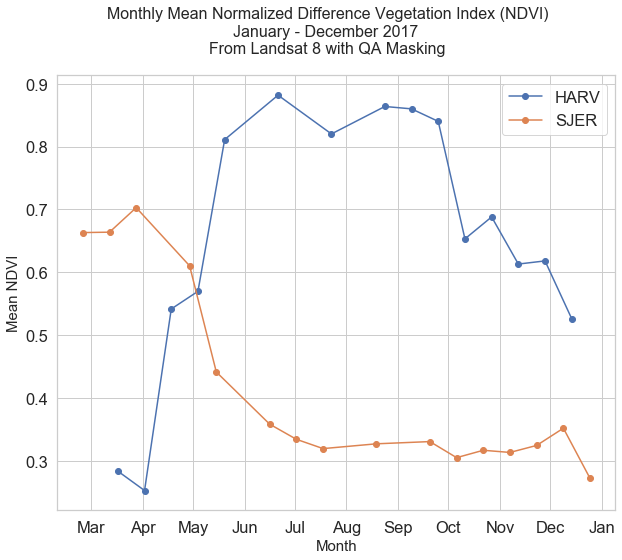

In [11]:
# Add only the plot code to this cell
# YOUR CODE HERE
# List objects needed for plot_NDVI() function
fname = "ndvi_df.csv"

outputs_path = os.path.join("data", "ndvi-automation", "outputs/")

title = "Monthly Mean Normalized Difference Vegetation Index (NDVI)" \
        "\nJanuary - December 2017 \nFrom Landsat 8 with QA Masking"

# plot SJER and HARV mean_NDVI per month
plot_NDVI(outputs_path, fname, "--", title)

### DO NOT REMOVE LINES BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")
end_time = datetime.now()
total_time = end_time - start_time

In [12]:
# Ignore this cell for the autograding tests


## Code Optimization
1. I have defined two functions which facilitates repetitive tasks.
    * Image processing, and NDVI calculations.
    * Plotting data using multiple csv files.
2. I have used two loops to automatically acquire directories name, sort subdirectory, acquire shape files to crop images.
3. I have used inner loop to open bands and calculate mean NDVI for each image.
4. I have used one composite list to store all data values, site and date information.
5. The list was changed to a dataframe and saved as csv file to recall later.

# Question 1 (10 points)

Imagine that you are planning NEON’s upcoming flight season to capture remote sensing data in these locations and want to ensure that you fly the area when the vegetation is the most green.

When would you recommend the flights take place for each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

Ans: Final plot with cleaned mean NDVI values for 2017 indicates that July-Oct. are best suited for flights to capture maximum "greenness" for the HARV and March/April for the SJER sites.
Our recommendation should be based on statistical analysis of multiple year of data for any site. Regard to SJER site, I have my reservations to recommend Mar/April period to measure maximum NDVI for reasons given in the additional note.

**Additional note** 
The  SJER site is located in the California which is impacted heavily by the El-Nino Southern Oscillations (ENSO). ENSO is a global weather pattern that begins in the Pacific. The ENSO period results in reduced precipitation in California. The precipitation data indicates that 2017 was an exceptionally dry and hot year and it is not a true representative of the normal vegetation growth in California. It is worth checking vegetation indices (NDVI) during La Nina seasons-a weather pattern with more than usual rainfall in the California, to obtain a real picture of vegetation growth and seasonality over both ENSO and La Nina seasons.  

# Question 2 (10 points)

How could you modify your workflow to look at vegetation changes over time in each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

The NOAA has been collecting earth's data using various Landsat satellites for over 40 years, there are multiple ways to look at vegetation changes over time. 
1. Plotting time series (2-3 decades of data) of mean NDVI by taking a composite value for each year (yearly mean NDVI) along with error bars or min-max NDVI values. This plot would provide information on the long term trends and how climate change (rising temperature due to the increase in carbon dioxide) is affecting plant growth. There is an interesting paradox that high CO2 will increase photosynthesis. However, proponent of this hypothesis have not into account the impact of heat and availability of moisture/water during growing season. Plotting long term record of mean NDVI, temperature, and soil moisture will help to answer some of the climate related impacts on the vegetation.  
2. Plotting duration of growth growth season over 2-3 decades. This plot would provide us information about changes in growing season such as early onset of growth season and/ or late onset of senescence (loss of green pigments in plants).

# Do not edit this cell! (40 points)

The notebook includes:
* at least 2 well documented and well named functions with appropriately formatted docstrings.

In [13]:
# Last sanity check before creating your plot

# Ensure that your dataframe is named 'ndvi_ts'
# and that the columns called: mean_ndvi and site

# These tests are not graded.

# Ensure the data is stored in a dataframe.
try:
    assert isinstance(ndvi_df, pd.DataFrame)
    print('Your data is stored in a DataFrame!')
except AssertionError:
    print('It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Check that dataframe contains the appropriate number of NAN values
try:
    assert ndvi_df.isna().sum()['mean_ndvi'] == 15
    print('Correct number of masked data values!')
except AssertionError:
    print('The amount of null data in your dataframe is incorrect.')

Your data is stored in a DataFrame!
The amount of null data in your dataframe is incorrect.


In [14]:
# Test your dataframe before cleaning the data to deal with clouds. 
# Ensure that your dataframe is named 'ndvi_ts_unclean'
# and that the columns called: mean_ndvi and site

# These tests are not graded.
# This is for data that hasn't been cleaned yet to deal 
# with clouds and serves as a half way sanity check.

# Ensure the data is stored in a dataframe.
try:
    assert isinstance(ndvi_ts_unclean, pd.DataFrame)
    print('Your data is stored in a DataFrame!')
except AssertionError:
    print('It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Ensure there are the correct amount of total entries in the dataframe.
try:
    assert len(ndvi_ts_unclean) == 46
    print('You have the correct number of data values!')
except AssertionError:
    print('You do not have the correct amount of data stored in your DataFrame.')

# Ensure there are the correct amount of entries for each site.
try:
    assert all(
        [site_count == 23 for site_count in ndvi_ts_unclean['site'].value_counts()])
    print('You have the correct amount of both sites!')
except AssertionError:
    print('One of your sites is either missing data or has extra data.')

# Ensure the minimum and maximum values in the mean_ndvi column are correct.
try:
    ndvi_min, ndvi_max = ndvi_ts_unclean['mean_ndvi'].min(), ndvi_ts_unclean['mean_ndvi'].max()
    assert ndvi_min == -0.0020918187219649553 and ndvi_max == 0.8629496097564697
    print('The minimum and maximum values in your ndvi_mean column are correct!')
except AssertionError:
    print('The minimum and maximum values in your ndvi_mean column are incorrect.')

NameError: name 'ndvi_ts_unclean' is not defined

In [ ]:
# This cell is not required but highly encouraged to break down the workflow.

# Create dataframe of NDVI without cleaning data to deal with clouds

# Important: to use the ungraded tests below as a sanity check, 
# name your dataframe 'ndvi_ts_unclean' and the columns: mean_ndvi and site

# YOUR CODE HERE


# Do not edit this cell! (20 points)

The notebook includes:
* a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code).

# Do not edit this cell! (20 points)

The notebook includes:
* additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

# Do not edit this cell! (20 points)

In addition to this notebook, the submission to the GitHub repository includes:
* One output .csv file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV